In [1]:
# Setup: Add project root to path
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /Users/Sakarias/QuantTrading


In [2]:
# Import required modules
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Core modules
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2
from core.portfolio_manager import run_multi_asset_backtest, PortfolioConfig

# Risk management
from core.risk_manager import RiskManager, RiskConfig
from core.risk_dashboard import RiskDashboard

print("✅ All modules imported successfully")

✅ All modules imported successfully


## Step 1: Load Data and Generate Signals

Using ES and GC futures data with momentum signals.

In [3]:
# Load data
tickers = ['ES', 'GC']
start_date = '2010-01-01'
end_date = '2024-12-31'

print(f"Loading data for {tickers}...")
prices = load_assets(tickers=tickers, start_date=start_date, end_date=end_date)

for ticker, df in prices.items():
    print(f"\n{ticker}: {len(df)} bars, {df.index[0].date()} to {df.index[-1].date()}")
    print(f"  Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

Loading data for ['ES', 'GC']...

Loading 2 assets: ['ES', 'GC']
✓ ES: 6134 rows, 2000-09-18 to 2024-12-31
✓ GC: 6106 rows, 2000-08-30 to 2024-12-31

Common date range: 2000-09-18 to 2024-12-31
Filtered date range: 2010-01-01 to 2024-12-31

Total unique dates: 3773
  GC: 2 missing dates, filled 2, 0 remain

ALIGNMENT SUMMARY
ES: 3773/3773 valid dates (100.0%)
GC: 3773/3773 valid dates (100.0%)

ES: 3773 bars, 2010-01-04 to 2024-12-31
  Price range: $1014.25 - $6099.00

GC: 3773 bars, 2010-01-04 to 2024-12-31
  Price range: $1050.80 - $2788.50


In [4]:
# Generate signals
signal_generator = MomentumSignalV2(lookback=120, sma_filter=200)
multi_signal = SingleAssetWrapper(signal_generator)
signals = multi_signal.generate(prices)

print(f"✓ Generated signals for {len(signals)} assets")
for ticker in tickers:
    sig = signals[ticker]['Signal']
    n_long = (sig == 1).sum()
    print(f"  {ticker}: {n_long} long days ({n_long/len(sig)*100:.1f}%)")

✓ Generated signals for 2 assets
  ES: 3553 long days (94.2%)
  GC: 3553 long days (94.2%)


## Step 2: Baseline Backtest (No Risk Management)

Run standard backtest without risk manager to establish baseline.

In [5]:
print("="*60)
print("BASELINE BACKTEST (No Risk Management)")
print("="*60)

# Configure portfolio WITHOUT risk manager
config_baseline = PortfolioConfig(
    initial_capital=100000,
    rebalance_threshold=0.05,
    transaction_cost_bps=3.0
)

# Run backtest
result_baseline, equity_baseline, trades_baseline = run_multi_asset_backtest(
    signals_dict=signals,
    prices_dict=prices,
    config=config_baseline,
    return_pm=False
)

# Calculate metrics
metrics_baseline = result_baseline.calculate_metrics()

print(f"\nResults:")
print(f"  Total Return: {metrics_baseline['Total Return']:.2%}")
print(f"  CAGR: {metrics_baseline['CAGR']:.2%}")
print(f"  Sharpe Ratio: {metrics_baseline['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {metrics_baseline['Max Drawdown']:.2%}")
print(f"  Volatility: {metrics_baseline['Annual Volatility']:.2%}")
print(f"  Total Trades: {len(trades_baseline)}")
print(f"\n  Risk Metrics Collected: {result_baseline.risk_metrics is not None}")
print(f"  Violations Logged: {result_baseline.violations is not None}")

BASELINE BACKTEST (No Risk Management)

Results:
  Total Return: 243.54%
  CAGR: 8.59%
  Sharpe Ratio: 0.777
  Max Drawdown: -19.46%
  Volatility: 11.47%
  Total Trades: 32

  Risk Metrics Collected: False
  Violations Logged: False

Results:
  Total Return: 243.54%
  CAGR: 8.59%
  Sharpe Ratio: 0.777
  Max Drawdown: -19.46%
  Volatility: 11.47%
  Total Trades: 32

  Risk Metrics Collected: False
  Violations Logged: False


## Step 3: Backtest WITH Risk Management

Now run with RiskManager integrated - metrics collected automatically!

In [6]:
print("="*60)
print("WITH RISK MANAGEMENT (Integrated)")
print("="*60)

# Create risk manager with moderate settings
risk_config = RiskConfig(
    position_sizing_method='vol_adjusted',
    max_position_size=0.30,
    max_leverage=1.0,
    max_drawdown_stop=-0.25,  # Stop at -25%
    volatility_target=0.2,
    correlation_threshold=0.70
)

risk_mgr = RiskManager(risk_config)

# Configure portfolio WITH risk manager
config_risk = PortfolioConfig(
    initial_capital=100000,
    rebalance_threshold=0.05,
    transaction_cost_bps=3.0,
    risk_manager=risk_mgr,  # THIS IS NEW!
    rejection_policy='skip'
)

# Run backtest
result_risk, equity_risk, trades_risk = run_multi_asset_backtest(
    signals_dict=signals,
    prices_dict=prices,
    config=config_risk,
    return_pm=False
)

# Calculate metrics
metrics_risk = result_risk.calculate_metrics()

print(f"\nResults:")
print(f"  Total Return: {metrics_risk['Total Return']:.2%}")
print(f"  CAGR: {metrics_risk['CAGR']:.2%}")
print(f"  Sharpe Ratio: {metrics_risk['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {metrics_risk['Max Drawdown']:.2%}")
print(f"  Volatility: {metrics_risk['Annual Volatility']:.2%}")
print(f"  Total Trades: {len(trades_risk)}")

print(f"\n  ✅ Risk Metrics Collected: {result_risk.risk_metrics is not None}")
if result_risk.risk_metrics is not None:
    print(f"     - {len(result_risk.risk_metrics)} snapshots")
    
print(f"  ✅ Violations Logged: {result_risk.violations is not None}")
if result_risk.violations is not None and not result_risk.violations.empty:
    print(f"     - {len(result_risk.violations)} violations")

WITH RISK MANAGEMENT (Integrated)

Results:
  Total Return: 147.04%
  CAGR: 6.23%
  Sharpe Ratio: 0.778
  Max Drawdown: -14.83%
  Volatility: 8.20%
  Total Trades: 32

  ✅ Risk Metrics Collected: True
     - 3772 snapshots
  ✅ Violations Logged: True

Results:
  Total Return: 147.04%
  CAGR: 6.23%
  Sharpe Ratio: 0.778
  Max Drawdown: -14.83%
  Volatility: 8.20%
  Total Trades: 32

  ✅ Risk Metrics Collected: True
     - 3772 snapshots
  ✅ Violations Logged: True


## Step 4: Compare Results

Side-by-side comparison of backtest with vs without risk management.

In [7]:
# Create comparison table
comparison_data = [
    {
        'Method': 'Baseline (No Risk Mgmt)',
        'Total Return': f"{metrics_baseline['Total Return']:.2%}",
        'CAGR': f"{metrics_baseline['CAGR']:.2%}",
        'Sharpe': f"{metrics_baseline['Sharpe Ratio']:.3f}",
        'Max DD': f"{metrics_baseline['Max Drawdown']:.2%}",
        'Volatility': f"{metrics_baseline['Annual Volatility']:.2%}",
        'Trades': len(trades_baseline)
    },
    {
        'Method': 'With Risk Management',
        'Total Return': f"{metrics_risk['Total Return']:.2%}",
        'CAGR': f"{metrics_risk['CAGR']:.2%}",
        'Sharpe': f"{metrics_risk['Sharpe Ratio']:.3f}",
        'Max DD': f"{metrics_risk['Max Drawdown']:.2%}",
        'Volatility': f"{metrics_risk['Annual Volatility']:.2%}",
        'Trades': len(trades_risk)
    }
]

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("COMPARISON: BASELINE VS RISK MANAGEMENT")
print("="*80 + "\n")
display(comparison_df)


COMPARISON: BASELINE VS RISK MANAGEMENT



,Method,Total Return,CAGR,Sharpe,Max DD,Volatility,Trades
0,Baseline (No Risk Mgmt),243.54%,8.59%,0.777,-19.46%,11.47%,32
1,With Risk Management,147.04%,6.23%,0.778,-14.83%,8.20%,32


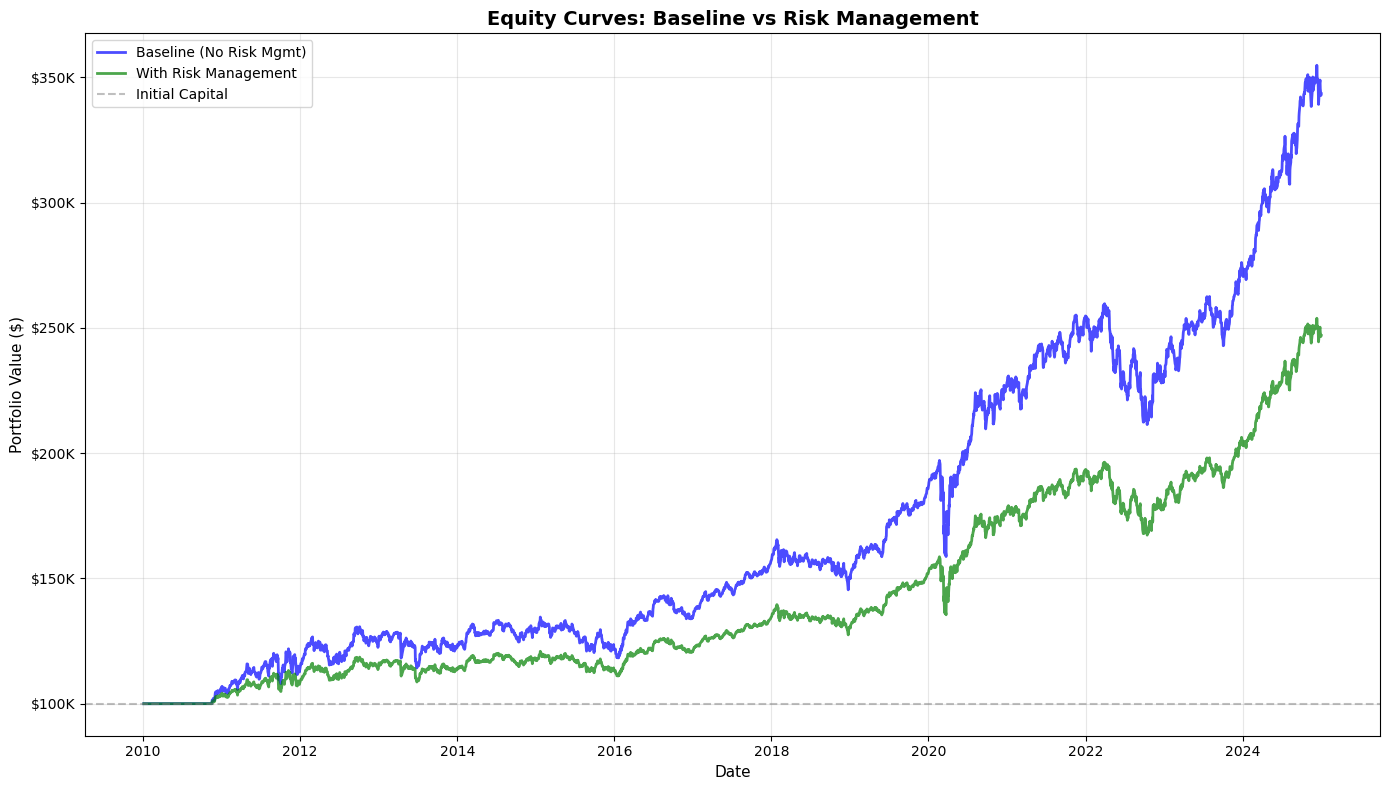

In [8]:
# Plot equity curves
fig, ax = plt.subplots(figsize=(14, 8))

# Baseline
if 'Date' in equity_baseline.columns:
    equity_baseline_plot = equity_baseline.set_index('Date')
else:
    equity_baseline_plot = equity_baseline

ax.plot(
    equity_baseline_plot.index,
    equity_baseline_plot['TotalValue'],
    label='Baseline (No Risk Mgmt)',
    linewidth=2,
    color='blue',
    alpha=0.7
)

# With risk management
if 'Date' in equity_risk.columns:
    equity_risk_plot = equity_risk.set_index('Date')
else:
    equity_risk_plot = equity_risk

ax.plot(
    equity_risk_plot.index,
    equity_risk_plot['TotalValue'],
    label='With Risk Management',
    linewidth=2,
    color='green',
    alpha=0.7
)

ax.axhline(y=100000, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Equity Curves: Baseline vs Risk Management', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

## Step 5: Examine Risk Metrics

The risk metrics were collected automatically during the backtest!

In [9]:
if result_risk.risk_metrics is not None:
    print("Risk Metrics Summary:")
    print(f"  Total snapshots: {len(result_risk.risk_metrics)}")
    print(f"\nColumns: {list(result_risk.risk_metrics.columns)}")
    
    display(result_risk.risk_metrics)
    
    print(f"\nRisk Metrics Statistics:")
    display(result_risk.risk_metrics[['leverage', 'num_positions', 'max_position_weight', 
                                      'portfolio_volatility']].describe())
else:
    print("⚠️ No risk metrics collected (risk_manager not configured)")

Risk Metrics Summary:
  Total snapshots: 3772

Columns: ['leverage', 'num_positions', 'max_position_weight', 'portfolio_volatility', 'date', 'drawdown']


,leverage,num_positions,max_position_weight,portfolio_volatility,date,drawdown
0,0.000000,0,0.000000,0.000000,2010-01-05,0.000000
1,0.000000,0,0.000000,0.000000,2010-01-06,0.000000
2,0.000000,0,0.000000,0.000000,2010-01-07,0.000000
3,0.000000,0,0.000000,0.000000,2010-01-08,0.000000
4,0.000000,0,0.000000,0.000000,2010-01-11,0.000000
...,...,...,...,...,...,...
3767,0.840015,2,0.441022,0.118784,2024-12-24,-0.016668
3768,0.840440,2,0.439652,0.119016,2024-12-26,-0.014048
3769,0.839120,2,0.438325,0.118897,2024-12-27,-0.022137
3770,0.838041,2,0.436268,0.118906,2024-12-30,-0.028653



Risk Metrics Statistics:


,leverage,num_positions,max_position_weight,portfolio_volatility
count,3772.000000,3772.000000,3772.000000,3772.000000
mean,0.668861,1.883881,0.346916,0.095487
std,0.176950,0.467773,0.092369,0.025250
min,0.000000,0.000000,0.000000,0.000000
25%,0.651841,2.000000,0.334598,0.093062
50%,0.688318,2.000000,0.357769,0.097757
75%,0.772605,2.000000,0.396380,0.109941
max,0.842681,2.000000,0.441095,0.121333


In [10]:
if result_risk.violations is not None and not result_risk.violations.empty:
    print("Violations Summary:")
    print(f"  Total violations: {len(result_risk.violations)}")
    print(f"\nViolation types:")
    display(result_risk.violations['type'].value_counts())
    print(f"\nAll violations:")
    display(result_risk.violations)
else:
    print("✅ No violations logged - all trades passed risk checks")

✅ No violations logged - all trades passed risk checks


## Step 6: Generate Risk Dashboard

Create interactive visualization from automatically collected metrics.

In [11]:
if result_risk.risk_metrics is not None:
    # Generate risk dashboard
    dashboard = RiskDashboard(output_dir=project_root / 'reports')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    report_path = project_root / 'reports' / f'risk_integration_dashboard_{timestamp}.html'
    
    print("Generating risk dashboard from integrated backtest...")
    
    dashboard.generate_dashboard(
        risk_metrics_df=result_risk.risk_metrics,
        violations_df=result_risk.violations if result_risk.violations is not None else None,
        correlation_matrix=risk_mgr.correlation_matrix,
        equity_df=equity_risk,
        title="Risk Management Dashboard - Phase 2 Integration",
        save_path=str(report_path)
    )
    
    print(f"\n✅ Dashboard saved to: {report_path}")
    print(f"\nOpen in browser to view interactive charts.")
else:
    print("⚠️ Cannot generate dashboard - no risk metrics collected")

Generating risk dashboard from integrated backtest...
✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_integration_dashboard_20251125_193433.html

✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_integration_dashboard_20251125_193433.html

Open in browser to view interactive charts.
✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_integration_dashboard_20251125_193433.html

✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_integration_dashboard_20251125_193433.html

Open in browser to view interactive charts.


## Step 7: Test Drawdown Stop

Configure aggressive drawdown stop and verify it triggers.

In [12]:
print("="*60)
print("TESTING DRAWDOWN STOP (Aggressive -15%)")
print("="*60)

# Create risk manager with aggressive drawdown stop
risk_config_aggressive = RiskConfig(
    position_sizing_method='equal_weight',
    max_position_size=0.30,
    max_leverage=1.0,
    max_drawdown_stop=-0.15,  # Very tight stop
)

risk_mgr_aggressive = RiskManager(risk_config_aggressive)

config_aggressive = PortfolioConfig(
    initial_capital=100000,
    rebalance_threshold=0.05,
    transaction_cost_bps=3.0,
    risk_manager=risk_mgr_aggressive,
    rejection_policy='skip'
)

# Run backtest
result_aggressive, equity_aggressive, trades_aggressive = run_multi_asset_backtest(
    signals_dict=signals,
    prices_dict=prices,
    config=config_aggressive,
    return_pm=False
)

metrics_aggressive = result_aggressive.calculate_metrics()

print(f"\nResults:")
print(f"  Trading Days: {len(equity_aggressive)}")
print(f"  Max Drawdown: {metrics_aggressive['Max Drawdown']:.2%}")
print(f"  Total Trades: {len(trades_aggressive)}")

# Check for STOP violations
if result_aggressive.violations is not None and not result_aggressive.violations.empty:
    stop_violations = result_aggressive.violations[result_aggressive.violations['type'] == 'STOP']
    if not stop_violations.empty:
        print(f"\n  ✅ Drawdown stop triggered!")
        print(f"     - Date: {stop_violations.iloc[0]['date']}")
        print(f"     - Reason: {stop_violations.iloc[0]['reason']}")
    else:
        print(f"\n  ℹ️ No drawdown stop triggered")
else:
    print(f"\n  ℹ️ No violations (stop not reached)")

TESTING DRAWDOWN STOP (Aggressive -15%)

Results:
  Trading Days: 3773
  Max Drawdown: -14.83%
  Total Trades: 32

  ℹ️ No violations (stop not reached)

Results:
  Trading Days: 3773
  Max Drawdown: -14.83%
  Total Trades: 32

  ℹ️ No violations (stop not reached)


## Summary

### Phase 2 Integration Complete! ✅

**What Changed:**
1. Added `risk_manager` parameter to `PortfolioConfig`
2. Modified `_run_backtest()` to:
   - Track daily returns per asset
   - Update correlation matrix
   - Check drawdown stops before trading
   - Collect risk metrics automatically
3. Extended `BacktestResult` to include risk metrics and violations
4. Modified `run_multi_asset_backtest()` to extract and return risk data

**Benefits:**
- Risk metrics collected **automatically** during backtest
- No manual simulation needed
- Drawdown stops actually work
- Easy to compare with/without risk management
- Backward compatible (risk_manager is optional)

**Next Steps (Phase 3 - Optional):**
- VaR/CVaR calculations
- Regime detection
- Dynamic position sizing based on regime
- Liquidity risk assessment
- Behavioral risk alerts